In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from typing import Any, Union, Literal

## (a) Implement the 90-degree rotation group (cyclic group) over a plane including: 
    (i) group element
    (ii) group product (__mul__)
    (iii) group inverse (__invert__)
    (iv) group action (__call__)

In [119]:
class RotationGroupElement():
    """
    Implementation of the cyclic rotation group via implemention of a group element.
    """
    def __init__(self, idx: int) -> None:
        """
        Parameters:
            idx: Index of group element. 
                 Corresponds with number of 90 degree rotations performed.
        """
        assert(idx in [0,1,2,3])
        self.idx = idx

    def __call__(self, img: torch.tensor) -> torch.tensor:
        """
        Group action. Rotates img by (idx * 90) degrees.

        Note: rotates last two dimensions by default so that we can apply the
              group action to any kernel/signal of shape (..., H,W) or (..., W,H)
        """
        return torch.rot90(img, k=self.idx, dims=[-1,-2])

    def __mul__(self, other):
        """
        Group product: (g * g')(x) = g(g'(x))
        """
        new_idx = (self.idx + other.idx) % 4
        return RotationGroupElement(new_idx)

    def __invert__(self):
        """
        Group inverse: (~g * g) = identity
        """
        new_idx = (4 - self.idx) % 4
        return RotationGroupElement(new_idx)

## Apply the group actions on an image and print (imshow) them.

In [120]:
def plot_img(img_tensor):
    plt.imshow(img_tensor.squeeze(), cmap='gray')
    plt.show()

In [121]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]) )
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]) )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

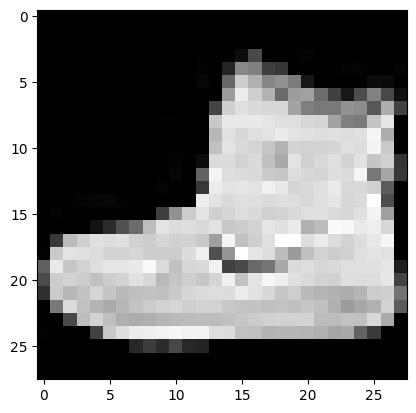

In [122]:
img = train_dataset[0][0]
plot_img(img)

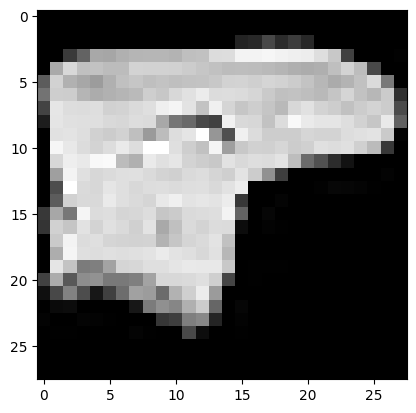

In [123]:
g = RotationGroupElement(2) # 180 degree rotation
plot_img(g(img))

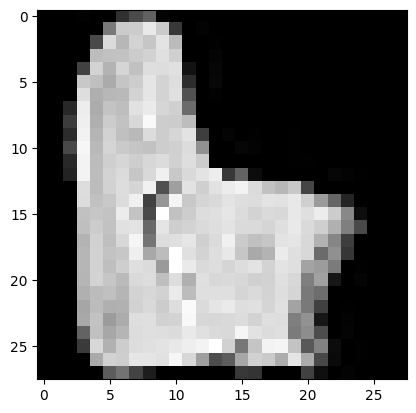

In [124]:
g = RotationGroupElement(1) # 90 degree rotation clockwise
plot_img(g(img))

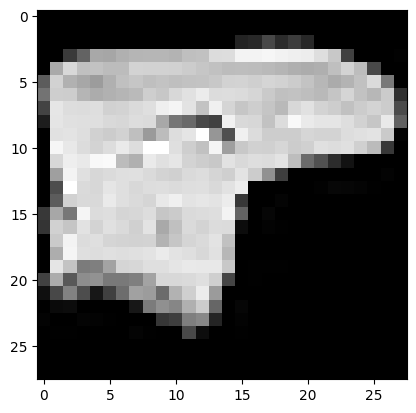

In [125]:
plot_img((g*g)(img)) # group product (composition) -> 180 degrees

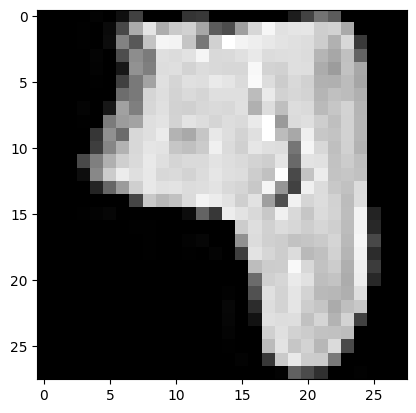

In [126]:
plot_img((~g)(img)) # inverse -> rotate 90 degrees counterclockwise

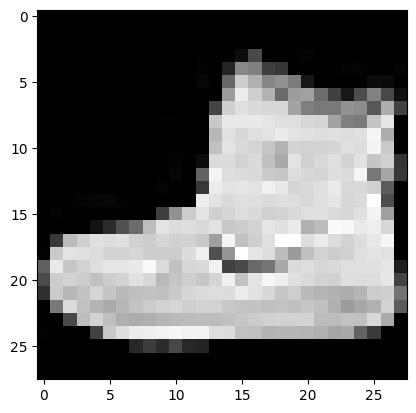

In [127]:
plot_img((~g*g)(img)) # inverse times original -> identity

## (b) Implement the lifting convolution, including: 
    (i) lifting kernel with: 
        input parameters size of the kernel
        input and output channel
        etc.
    (ii) forward function.

In [89]:
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

In [535]:
class LiftingConv(nn.Module):
    def __init__(self,         
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: float = 0
        ):
        """
        input shape:
            (N, Ci, Hi, Wi )
            N = batch size
            Ci = input channels
            Hi = input height
            Wi = input Width

        output shape:
            (N, Co, G, Ho, Wo )
            N = batch size
            Co = output channels
            G = group order
            Ho = output height
            Wo = output Width
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = torch.nn.Parameter(torch.randn((out_channels, in_channels, kernel_size, kernel_size)) )


    def forward(self, input: Tensor):
        
        # convolve kernel with input under all group transformations:
        output = []
        for g in [RotationGroupElement(i) for i in [0,1,2,3]]:
            output.append(
                F.conv2d(input=input, 
                         weight=g(self.weight), 
                         stride=self.stride, 
                         padding=self.padding))

        output = torch.stack(output)

        # reshape:
        # (group_order, batch_size, out_channels, H, W) -> 
        # (batch_size, out_channels, group_order, H, W)        
        output = output.permute(1,2,0,3,4) 

        return output

## Applying the lifting convolution using a sobel filter to visualize the filter rotations:

In [569]:
lc = LiftingConv(1, 1, 3, 1, 1)
lc.weight = torch.nn.Parameter(torch.tensor(
    [[[[1,2,1],
       [0,0,0],
       [-1,-2,-1]
    ]]], dtype=torch.float32
))

In [570]:
x,y = next(iter(train_loader))

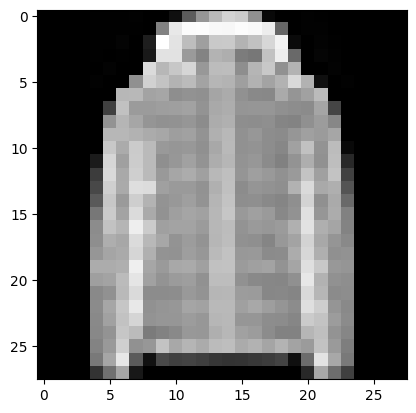

In [571]:
plot_img(x[0,0,:,:])

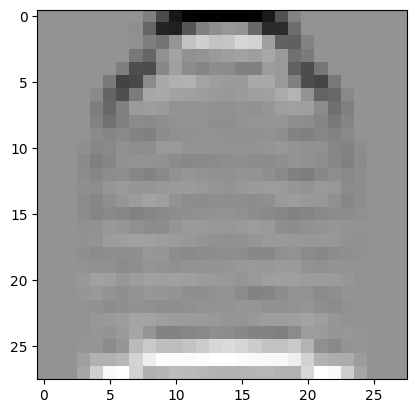

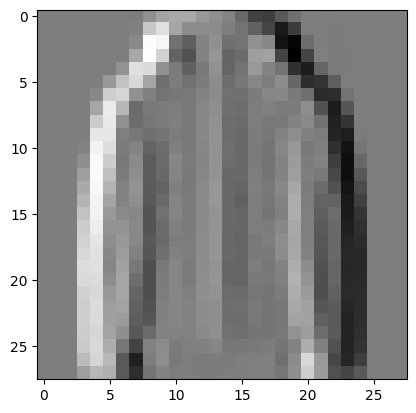

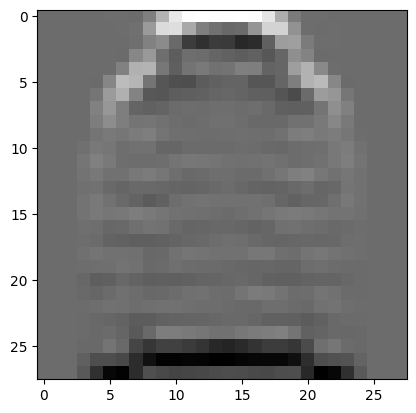

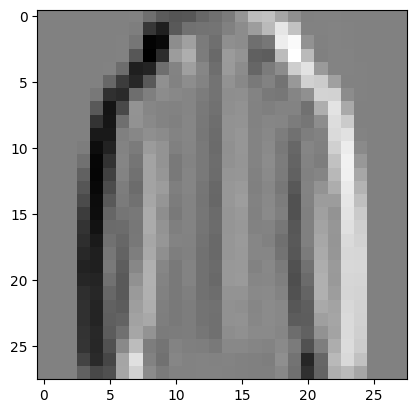

In [572]:
plot_img(lc(x)[0,0,0,:,:].detach())
plot_img(lc(x)[0,0,1,:,:].detach())
plot_img(lc(x)[0,0,2,:,:].detach())
plot_img(lc(x)[0,0,3,:,:].detach())

## (c) Implement the group convolution, including: 
    (i) group convolution kernel (with input parameters size of the kernel, input and output channel, etc. )
    (ii) the transformation of the group action
    (iii) bilinear interpolation (sampling)
    (iv) forward function.
    (Note that other weight initializations and interpolations are welcome to test/include.)


In [573]:
class GroupConv(nn.Module):
    def __init__(self,         
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: float = 1,
        group_order: int = 4
        ):
        """
        input shape:
            (N, Ci, Hi, Wi )
            N = batch size
            Ci = input channels
            G = group_order
            Hi = input height
            Wi = input Width

        output shape:
            (N, Co, G, Ho, Wo )
            N = batch size
            Co = output channels
            G = group order
            Ho = output height
            Wo = output Width
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = torch.nn.Parameter(torch.randn((out_channels, in_channels * group_order, kernel_size, kernel_size)) )


    def forward(self, input: Tensor):

        
        # swap axes so all channels of the same group index appear consecutively
        # this allows easy shifting of the convolved filter
        # (batch_size, in_channels, group_order, H, W) -> 
        # (batch_size, group_order, in_channels, H, W)
        input = input.swapaxes(1,2) 

        # reshape input:
        batch_size, group_order, in_channels, H, W = input.shape
        flattened_input = input.reshape(batch_size, in_channels * group_order, H, W)

        # convolve kernel
        output = []
        for i, g in [(i,RotationGroupElement(i)) for i in [0,1,2,3]]:
            output.append(
                F.conv2d(input=flattened_input, 
                         weight=torch.roll(g(self.weight), shifts=i*in_channels, dims=1), 
                         stride=self.stride, 
                         padding=self.padding))

        output = torch.stack(output)

        # (group_order, batch_size, out_channels, H, W) -> 
        # (batch_size, out_channels, group_order, H, W)        
        output = output.permute(1,2,0,3,4) 

        # return output
        return output

In [574]:
lc_out_channels = 8
gc_in_channels = lc_out_channels

lc = LiftingConv(1, 8, 3, 1, 1)
lc(x).shape

torch.Size([64, 8, 4, 28, 28])

In [575]:
gc = GroupConv(in_channels=gc_in_channels, out_channels=13)
gc.forward(lc(x)).shape

torch.Size([64, 13, 4, 28, 28])

## Lifting Convolution is Rotation Equivariant

In [576]:
g = RotationGroupElement(1)

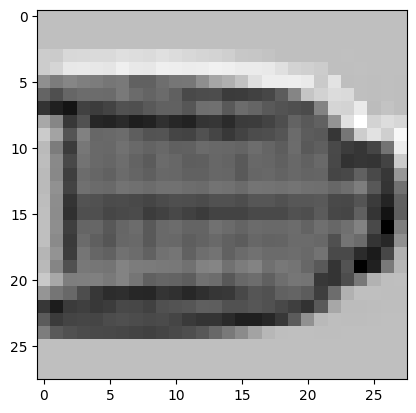

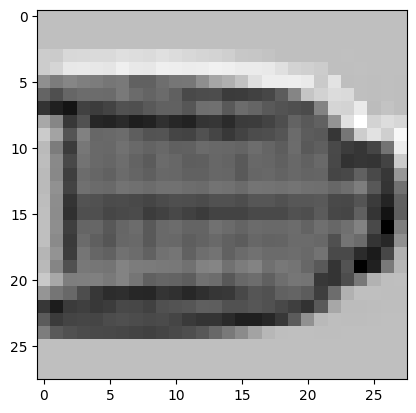

In [577]:
img1 = lc(g(x)).detach() # apply filter to rotated image
img2 = g(lc(x))[:,:,[3,0,1,2],:,:].detach() # apply filter to original image, and rotate output (i.e rotate and shift by 1)

random_idx = np.random.choice([0,1,2,3])
plot_img(img1[0,0,random_idx,:,:])
plot_img(img2[0,0,random_idx,:,:])

# Group Convolution is rotation equivariant:

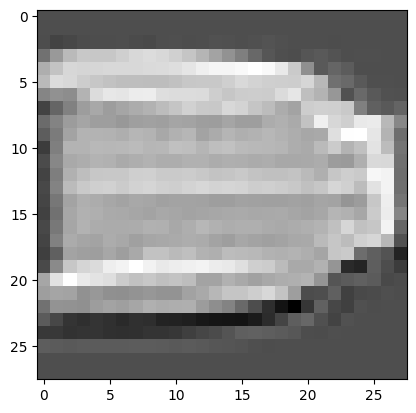

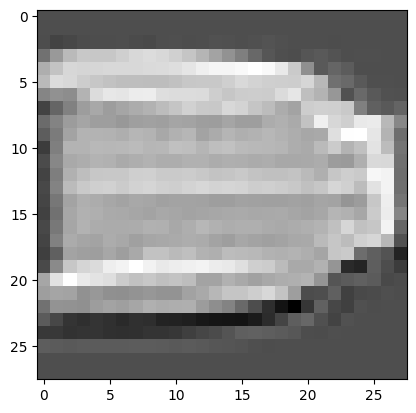

In [578]:
img1 = gc(lc(g(x))).detach() # apply filter to rotated image
img2 = g(gc(lc(x)))[:,:,[3,0,1,2],:,:].detach() # apply filter to original image, and rotate output (i.e rotate and shift by 1)

random_idx = np.random.choice([0,1,2,3])
plot_img(img1[0,0,random_idx,:,:])
plot_img(img2[0,0,random_idx,:,:])